# Propensity Modeling

In [1]:
import numpy as np
import pandas as pd
import pickle

from time import time
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import cycle
# pd.set_option('display.max_columns', 1000)

##  1. Data

In [2]:
%%time
with open("../Data/Feature_Engineering/df_features_normalize.p", "rb" ) as f:
    data_features = pickle.load(f)    
with open( "../Data/Feature_Engineering/df_label.p", "rb" ) as f:
    data_label = pickle.load(f)

CPU times: user 769 ms, sys: 6 s, total: 6.77 s
Wall time: 3min 1s


In [3]:
%%time
X = data_features
Y = data_label

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs


### 1.1 Split data to training set, validation set and test set

In [4]:
print(X.shape)
bar_80 = np.floor(X.shape[0]*0.8).astype(int)
bar_80=bar_80+1
bar_80

(220047, 2357)


176038

In [5]:
X_train=X[:bar_80]
Y_train=Y[:bar_80]
X_test=X[bar_80:]
Y_test=Y[bar_80:]

## 2.0 Feature Selection

In [6]:
%%time
clf=RandomForestClassifier(n_estimators=100,criterion='gini',max_features= 10, 
                           min_samples_leaf=3, bootstrap= False, max_depth= 25, 
                           min_samples_split= 15)

clf.fit(X_train, Y_train)

clf.feature_importances_ 
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(220047, 65)
CPU times: user 25.8 s, sys: 989 ms, total: 26.8 s
Wall time: 27 s


In [7]:
X_train=X_new[:bar_80]
Y_train=Y[:bar_80]
X_test=X_new[bar_80:]
Y_test=Y[bar_80:]
print(X_train.shape)

(176038, 65)


## 2. Classifier list


|  Parameters  |  Explanation |  
|---|---|---|---|---|
|  n_estimators | The number of trees in the forest  |   
| criterion  | The function to measure the quality of a split.  |   
|  max_depth | The number of features to consider when looking for the best split  |   
|  max_depth | The maximum depth of the tree.  |   
|  min_samples_split |   |  
| min_samples_leaf  |   |  
| max_features  |   |  
| max_leaf_nodes  |   |   
| bootstrap  |   |   
| oob_score  |   |   
|  n_jobs |   |   
|  random_state |   |   
|  verbose |   |  
|  warm_start |   |   
|  class_weight |   |   




In [10]:
# Optimal Classifiers:
clf1=RandomForestClassifier(n_estimators=100,criterion='gini',max_features= 10, 
                           min_samples_leaf=3, bootstrap= False, max_depth= 25, 
                           min_samples_split= 15)

clf2=AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=5, n_estimators= 500)
clf3=GradientBoostingClassifier(learning_rate=0.1, n_estimators=300,max_depth=10,min_samples_split=100,
                               min_samples_leaf=50, max_features='sqrt')

# ensemble model
# eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[1,1,1])
eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[3,1,5])

In [11]:
%%time
clf1 = clf1.fit(X_train, Y_train)
print('1st fit done...')
clf2 = clf2.fit(X_train, Y_train)
print('2nd fit done...')
clf3 = clf3.fit(X_train, Y_train) 
print('3rd fit done.')
# clf3 would take a long time, roughtly 15mins

1st fit done...
2nd fit done...
3rd fit done.
CPU times: user 4min 34s, sys: 612 ms, total: 4min 35s
Wall time: 4min 35s


In [12]:
%%time
# ensemble model
eclf = eclf.fit(X_train, Y_train)

CPU times: user 4min 38s, sys: 1.65 s, total: 4min 40s
Wall time: 4min 47s


**combination 1**

In [15]:
%%time
# eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[1,1,1])
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.934081665114
CPU times: user 1.72 s, sys: 35 ms, total: 1.76 s
Wall time: 2.18 s


**combination 2**

In [21]:
%%time
# eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[2,1,3])
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print(classification_report(Y_test, Y_pred))

Classification accuracy rate is:  0.940057715467
             precision    recall  f1-score   support

          0       0.95      0.98      0.96     37065
          1       0.85      0.75      0.80      6944

avg / total       0.94      0.94      0.94     44009

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 1.8 s


**combination 3**

In [13]:
%%time
#cheat:

# eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[3,1,5])
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print(classification_report(Y_test, Y_pred))

Classification accuracy rate is:  0.940739394215
             precision    recall  f1-score   support

          0       0.95      0.98      0.97     37065
          1       0.86      0.75      0.80      6944

avg / total       0.94      0.94      0.94     44009

CPU times: user 1.76 s, sys: 42 ms, total: 1.8 s
Wall time: 1.92 s


In [24]:
%%time
# Real
# eclf = VotingClassifier(estimators=[('rf', clf1), ('ab', clf2), ('gb', clf3)], voting='soft', weights=[3,1,5])
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print(classification_report(Y_test, Y_pred))

Classification accuracy rate is:  0.94076211684
             precision    recall  f1-score   support

          0       0.95      0.98      0.97     37065
          1       0.86      0.75      0.80      6944

avg / total       0.94      0.94      0.94     44009

CPU times: user 1.75 s, sys: 7 ms, total: 1.76 s
Wall time: 1.76 s


**combination 4**

In [25]:
%%time
eclf = VotingClassifier(estimators=[('rf', clf1),('gb', clf3)], voting='soft', weights=[2,3])
eclf = eclf.fit(X_train, Y_train)
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))
print(classification_report(Y_test, Y_pred))

Classification accuracy rate is:  0.940830284714
             precision    recall  f1-score   support

          0       0.95      0.98      0.97     37065
          1       0.86      0.75      0.80      6944

avg / total       0.94      0.94      0.94     44009

CPU times: user 4min 28s, sys: 167 ms, total: 4min 28s
Wall time: 4min 28s


### 2.1 Save Model

In [16]:
%%time
path = '../Data/Propensity_Modeling/VotingClassifier.pkl'
joblib.dump(eclf, path)

# clf=RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
#                            min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None,  bootstrap=True, 
#                            oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False,
#                            class_weight=None)

CPU times: user 81 ms, sys: 36 ms, total: 117 ms
Wall time: 118 ms


In [32]:
# Y_predict=clf.predict(X_test)

### 2.2 Load Model

In [10]:
%%time
# load the model from disk
path = '../Data/Propensity_Modeling/VotingClassifier.pkl'
eclf = joblib.load(path)

# result = loaded_model.score(X_test, Y_test)
# print(result)

CPU times: user 130 ms, sys: 437 ms, total: 567 ms
Wall time: 567 ms


## 3. Result Analysis

### 3.1 Accuracy Rate

In [11]:
# # Result of AdaBoost:
# %%time
# Y_pred = eclf.predict(X_test)
# print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.922924856279
CPU times: user 3.88 s, sys: 150 ms, total: 4.03 s
Wall time: 4.03 s


In [9]:
1+1

2

In [14]:
%%time
#Cheat
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.940739394215
CPU times: user 1.71 s, sys: 38 ms, total: 1.74 s
Wall time: 1.74 s


In [10]:
%%time
Y_pred = eclf.predict(X_test)
print('Classification accuracy rate is: ',sum(Y_pred==Y_test)/len(Y_test))

Classification accuracy rate is:  0.934899679611
CPU times: user 6.09 s, sys: 576 ms, total: 6.66 s
Wall time: 6.71 s


In [11]:
# Result with 100 trees
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96     37065
          1       0.85      0.72      0.78      6944

avg / total       0.93      0.93      0.93     44009



In [13]:
1-sum(Y_test)/len(Y_test)

0.84221409257197388

### 3.2 Confusion matrix

In [15]:
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix is:
 [[36203   862]
 [ 1746  5198]]

Plot of Confusion Matrix is:


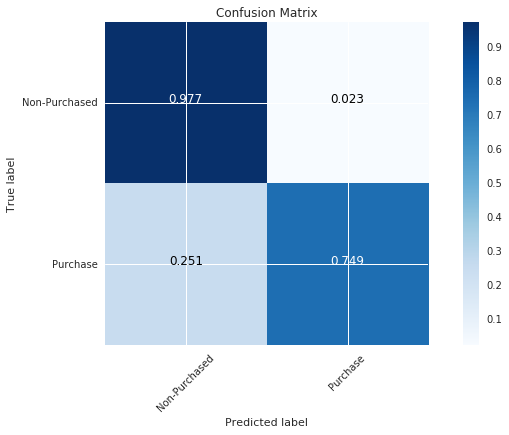

In [16]:
# Cheat
Y_pred = eclf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

Confusion Matrix is:
 [[36179   886]
 [ 1979  4965]]

Plot of Confusion Matrix is:


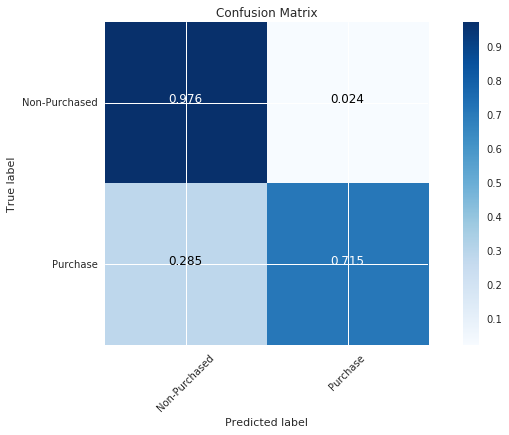

In [14]:
Y_pred = eclf.predict(X_test)
# cfm = confusion_matrix(y_true, y_pred, labels
cfm = confusion_matrix(Y_test, Y_pred, labels=[0, 1])
print('Confusion Matrix is:\n',confusion_matrix(Y_test, Y_pred))
print('\nPlot of Confusion Matrix is:')
plt.figure(figsize=(10,6))
plot_confusion_matrix(cfm, classes=["Non-Purchased", "Purchase"], normalize=True)

**feature Importance check**

In [16]:
clf.feature_importances_

array([ 0.02,  0.  ,  0.04, ...,  0.  ,  0.  ,  0.  ])

### 3.3 ROC 

In [21]:
n_classes=1
Y_prob = eclf.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, Y_prob[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_prob[:,1].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

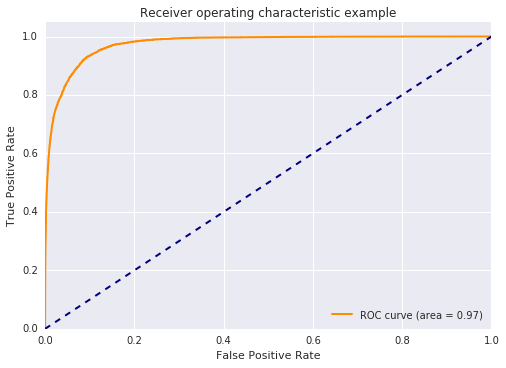

In [22]:
# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


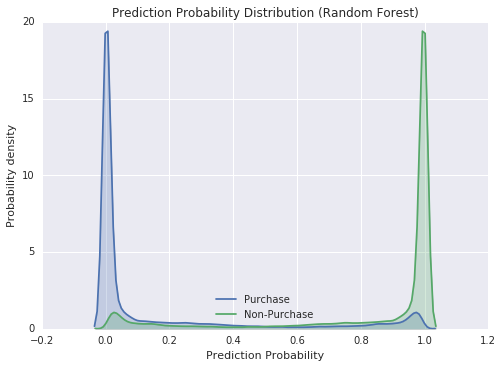

In [23]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob = eclf.predict_proba(X_test)

sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (Random Forest)')

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


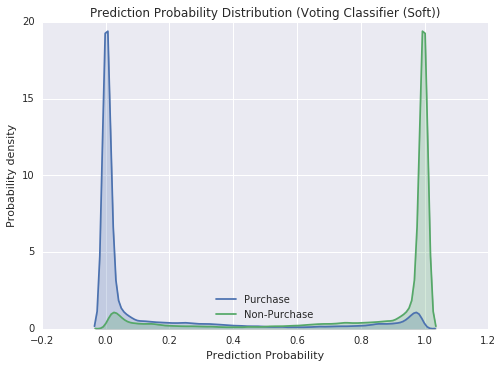

In [24]:
import seaborn as sns
sns.set(color_codes=True)

Y_prob = eclf.predict_proba(X_test)

sns.kdeplot(Y_prob[:,1], shade=True, label="Purchase");
sns.kdeplot(Y_prob[:,0], shade=True, label="Non-Purchase");

# sns.kdeplot(Y_prob[:,1], shade=True,cut=0, label="Purchase");
# sns.kdeplot(Y_prob[:,0], shade=True,cut=0,label="Non-Purchase");

plt.xlabel('Prediction Probability')
plt.ylabel('Probability density')
plt.title(r'Prediction Probability Distribution (Voting Classifier (Soft))')

---